In [41]:
!pip install pandas
!pip install xlrd
!pip install 'pandas-profiling==2.8.0'
!pip install seaborn
from scipy.stats import chi2
from scipy.stats import chi2_contingency

You should consider upgrading via the '/home/esteban/Documentos/cda/jupyter/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/esteban/Documentos/cda/jupyter/bin/python -m pip install --upgrade pip' command.


You should consider upgrading via the '/home/esteban/Documentos/cda/jupyter/bin/python -m pip install --upgrade pip' command.


You should consider upgrading via the '/home/esteban/Documentos/cda/jupyter/bin/python -m pip install --upgrade pip' command.


In [3]:
import pandas as pd
import seaborn as sns
from pandas_profiling import ProfileReport
from matplotlib import pyplot

sns.set_style(style="whitegrid")

In [53]:
df_hurtos = pd.concat([
    pd.read_excel('data/hurto-de-automotores-2017_0.xls', skiprows=9),
    pd.read_excel('data/hurto-de-automotores-2018_0.xls', skiprows=8),
    pd.read_excel('data/hurto-de-automotores-2018_1.xls', skiprows=9),
    pd.read_excel('data/hurto-de-automotores-2019_0.xls', skiprows=8)
])


# Limpieza

In [54]:
# Correción de valores de edad y cantidad. 
# Edad -1 representa que no se conoce la edad del individuo
# Cantidad 1000 se borra en un paso posterior.
df_hurtos['Edad'] = df_hurtos['Edad'].fillna('-1')
df_hurtos['Edad'] = df_hurtos['Edad'].astype(str)
df_hurtos = df_hurtos[df_hurtos['Edad'] != '-']
df_hurtos = df_hurtos[df_hurtos['Edad'] != '-1']

# Corrección de tipos.
cols_str = [
    'Fecha','Hora', 'Departamento', 'Municipio', 'Día', 'Barrio', 'Zona', 'Clase de sitio', 
    'Arma empleada', 'Móvil Agresor', 'Móvil Victima', 'Sexo', 'Estado civil' ,
    'País de nacimiento','Clase de empleado', 'Profesión', 'Escolaridad', 'Código DANE', 'CLASE',
    'MARCA', 'LINEA', 'MODELO', 'COLOR']
for col in cols_str:
    df_hurtos[col] = df_hurtos[col].astype(str)

df_hurtos['Edad'] = df_hurtos['Edad'].astype('int64')

# Remoción de duplicados
df_hurtos.drop_duplicates(inplace=True)

# Remoción de valores atípicos/outliers. 
# 1. Constantes
df_hurtos.drop(columns=['Cantidad', 'Profesión', 'Zona', 'Barrio', 'País de nacimiento'], inplace=True)
# 2. Registros con edad mayor a 110
df_hurtos = df_hurtos[df_hurtos['Edad'] < 110]

# Creación de nuevas columnas
df_hurtos['Fecha'] = df_hurtos['Fecha'].apply(lambda x: x[:11])
df_hurtos['M'] = df_hurtos['Fecha'].apply(lambda x: x[5:7])
df_hurtos['Mes'] = df_hurtos['Fecha'].apply(lambda x: x[5:7]).astype(int)


# Categorización de la variable Hora
def hora_to_cat(hora):
    if hora == 'na':
        return "No_especificada"
    hora = int(hora)

    if hora > 0 and hora <= 4:
        return '(00-04]'
    if hora > 4 and hora <= 8:
        return '(04-08]'
    if hora > 8 and hora <= 12:
        return '(08-12]'
    if hora > 12 and hora <= 16:
        return '(12-16)'
    if hora > 16 and hora <= 20:
        return '(16-20]'
    if hora == 0 or hora > 20:
        return '(20-24]'
df_hurtos['Hora_Cat'] = df_hurtos['Hora'].apply(lambda hora: hora_to_cat(hora[:2]))


def mes_to_trimestre(mes):
    if mes <= 3:
        return 'PRIMER TIMESTRE'
    if mes > 3 and mes <= 6:
        return 'SEGUNDO TRIMESTRE'
    if mes > 6 and mes <= 9:
        return 'TERCER TRIMESTRE'
    if mes > 9:
        return 'CUARTO TRIMESTRE'
    
df_hurtos['Trimestre'] = df_hurtos['Mes'].apply(lambda mes: mes_to_trimestre(mes))


def edad_to_grupo_etario(x):
    if x['Edad']<=31:
        return 'de_0_a_31'
    elif x['Edad'] > 31 and x['Edad'] <=38:
        return 'de_32_a_38' 
    elif x['Edad'] > 38 and x['Edad'] <=49:
        return 'de_39_a_49'
    else: 
        return 'de_50_a_99' 

df_hurtos['Grupo_Etario'] = df_hurtos.apply(edad_to_grupo_etario,axis=1)


In [6]:
colores_dict = {
    'ABANO': 'BLANCO', 'BEIGE': 'BLANCO', 'BLANCO': 'BLANCO', 'BLANCO Y VERDE': 'BLANCO', 'CHAMPAÑA': 'BLANCO', 'CREMA': 'BLANCO', 'MARFIL': 'BLANCO', 'PERLA': 'BLANCO',
    'SAHARA': 'BLANCO', 

    'ACEITUNA': 'VERDE', 'BOSQUE': 'VERDE', 'JADE': 'VERDE', 'LIMON': 'VERDE', 'VERDE': 'VERDE', 'VERDE OSCURO': 'VERDE', 

    'BAMBOO': 'CAFE','CAFE': 'CAFE', 'CARAMELO': 'CAFE', 'HABANO': 'CAFE', 'MARRON': 'CAFE', 'PARDO LAGUNA': 'CAFE', 'ROBLE': 'CAFE', 'TABACO': 'CAFE', 'TERRANOVA': 'CAFE',

    'ACERO': 'GRIS', 'CENIZA GRAFITO': 'GRIS', 'CROMADO': 'GRIS', 'ESTRATO DE PERLA':'GRIS', 'GRAFITO': 'GRIS', 'GRIS': 'GRIS', 'GRIS PLATINO': 'GRIS', 'PLATA': 'GRIS',
    'PLATA NIQUEL': 'GRIS','PLATEADO': 'GRIS', 'PLATINO': 'GRIS', 'STRATO PLATA': 'GRIS', 'SILICE TORNADO': 'GRIS', 'TOLEDANO': 'GRIS',

    'ACUARELA': 'AZUL', 'AZUL': 'AZUL', 'AZUL BAHIA': 'AZUL', 'AZUL BALTICO': 'AZUL', 'AZUL CIELO': 'AZUL', 'AZUL LAGUNA': 'AZUL', 'AZUL LISBOA' : 'AZUL', 
    'AZUL MEDIO': 'AZUL', 'AZUL Y BLANCO': 'AZUL', 'AZUL ZAFIRO': 'AZUL', 'CELESTE': 'AZUL', 'CIELO': 'AZUL', 'TURQUEZA': 'AZUL', 'ZAFIRO': 'AZUL',

    'BRONCE': 'NARANJA', 'COBRE': 'NARANJA', 'FUEGO': 'NARANJA', 'LADRILLO': 'NARANJA', 'MANDARINA': 'NARANJA', 'NARANJA': 'NARANJA', 'OTOÑAL': 'NARANJA', 
    'ZAPOTE': 'NARANJA',

    'BRUMA': 'MORADO', 'FIRMAMENTO': 'MORADO', 'IMPERIAL': 'MORADO', 'LILA': 'MORADO', 'MORADO CORDOBES': 'MORADO', 'VINOTINTO': 'MORADO', 'VIOLETA': 'MORADO', 

    'CEREZA': 'ROJO', 'ROJO': 'ROJO','ROJO - BLANCO': 'ROJO','ROJO-MARRON-ROYAL': 'ROJO','ROJO-VERDE': 'ROJO', 'TERRACOTA': 'ROJO',

    'NEGRO': 'NEGRO', 'NEGRO GRAFITO': 'NEGRO', 'NEGRO Y BLANCO': 'NEGRO', 'NEGRO Y NIQUEL': 'NEGRO',  

    'CINZA EJECUTIVO': 'OTRO', 'CLASICO': 'OTRO', 'COLONIAL': 'OTRO', 'METALIZADO': 'OTRO', 'NO REPORTADO': 'OTRO', 'PRIMER': 'OTRO', 'QUARZO': 'OTRO', 
    'SAFARI': 'OTRO', 'VARIOS COLORES': 'OTRO', '-': 'OTRO',

    'AMARILLO': 'AMARILLO', 'AMARILLO TRANSITO': 'AMARILLO', 'AMARILLO Y BLANCO': 'AMARILLO', 'AMARILLO Y NEGRO': 'AMARILLO', 'DORADO': 'AMARILLO', 
    'MOSTAZA': 'AMARILLO', 'ORO': 'AMARILLO'
}

In [7]:
# Agrupación de colores
df_hurtos['COLOR'] = df_hurtos['COLOR'].apply(lambda c: colores_dict[c])

In [8]:
report = ProfileReport(df_hurtos)
report.to_file('Perfilamiento de hurto a vehículos.html')

Export report to file: 100%|██████████| 1/1 [00:00<00:00, 23.34it/s]


In [9]:
df_hurtos.head()

,Fecha,Departamento,Municipio,Día,Hora,Clase de sitio,Arma empleada,Móvil Agresor,Móvil Victima,Edad,...,Clase de empleado,Escolaridad,Código DANE,CLASE,MARCA,LINEA,MODELO,COLOR,Mes,Hora_Cat
1,2017-01-01,CUNDINAMARCA,BOGOTÁ D.C. (CT),Domingo,00:00:00,VIAS PUBLICAS,SIN EMPLEO DE ARMAS,A PIE,A PIE,18,...,EMPLEADO PARTICULAR,PRIMARIA,11001000.0,AUTOMOVIL,NO REPORTADO,LINEA STANDARD,2015,AZUL,01,(20-24]
2,2017-01-01,MAGDALENA,CIÉNAGA,Domingo,00:00:00,CASAS DE HABITACION,SIN EMPLEO DE ARMAS,A PIE,A PIE,37,...,EMPLEADO PARTICULAR,SECUNDARIA,47189000.0,BUSETA,NO REPORTADO,LINEA STANDARD,2000,VERDE,01,(20-24]
3,2017-01-01,TOLIMA,IBAGUÉ (CT),Domingo,00:00:00,VIAS PUBLICAS,SIN EMPLEO DE ARMAS,A PIE,A PIE,52,...,EMPLEADO PARTICULAR,PRIMARIA,73001000.0,AUTOMOVIL,CHEVROLET,SPARK,2008,AMARILLO,01,(20-24]
4,2017-01-01,VALLE,CALI (CT),Domingo,08:00:00,VIAS PUBLICAS,LLAVE MAESTRA,A PIE,A PIE,42,...,EMPLEADO PARTICULAR,SUPERIOR,76001000.0,AUTOMOVIL,CHEVROLET,SPRINT,1992,ROJO,01,(04-08]
5,2017-01-01,VALLE,CALI (CT),Domingo,08:00:00,VIAS PUBLICAS,LLAVE MAESTRA,A PIE,A PIE,40,...,EMPLEADO PARTICULAR,TECNICO,76001000.0,AUTOMOVIL,RENAULT,R 9,1995,ROJO,01,(04-08]


In [143]:
# Trimestre, Departamento
df_hurtos_mes_detartamento_c = pd.crosstab(index=df_hurtos.Departamento,columns=df_hurtos["Trimestre"],margins=True)
df_hurtos_top = df_hurtos_mes_detartamento_c.sort_values("All", ascending=False).head(11)
df_hurtos_top

Trimestre,CUARTO TRIMESTRE,PRIMER TIMESTRE,SEGUNDO TRIMESTRE,TERCER TRIMESTRE,All
Departamento,,,,,
All,7627,9228,9703,9989,36547
CUNDINAMARCA,3039,3622,3803,4063,14527
VALLE,1827,1919,2122,2187,8055
ANTIOQUIA,1125,1454,1577,1596,5752
CAUCA,282,389,364,362,1397
ATLÁNTICO,259,371,338,309,1277
NARIÑO,179,196,177,238,790
GUAJIRA,130,222,223,210,785
CESAR,138,216,233,181,768


In [144]:
df_hurtos_cross_div = df_hurtos_top.div(df_hurtos_top.All, axis=0)
df_hurtos_cross_div = df_hurtos_cross_div.drop(['All'], axis=1).drop('All', axis=0)

<AxesSubplot:xlabel='Departamento'>

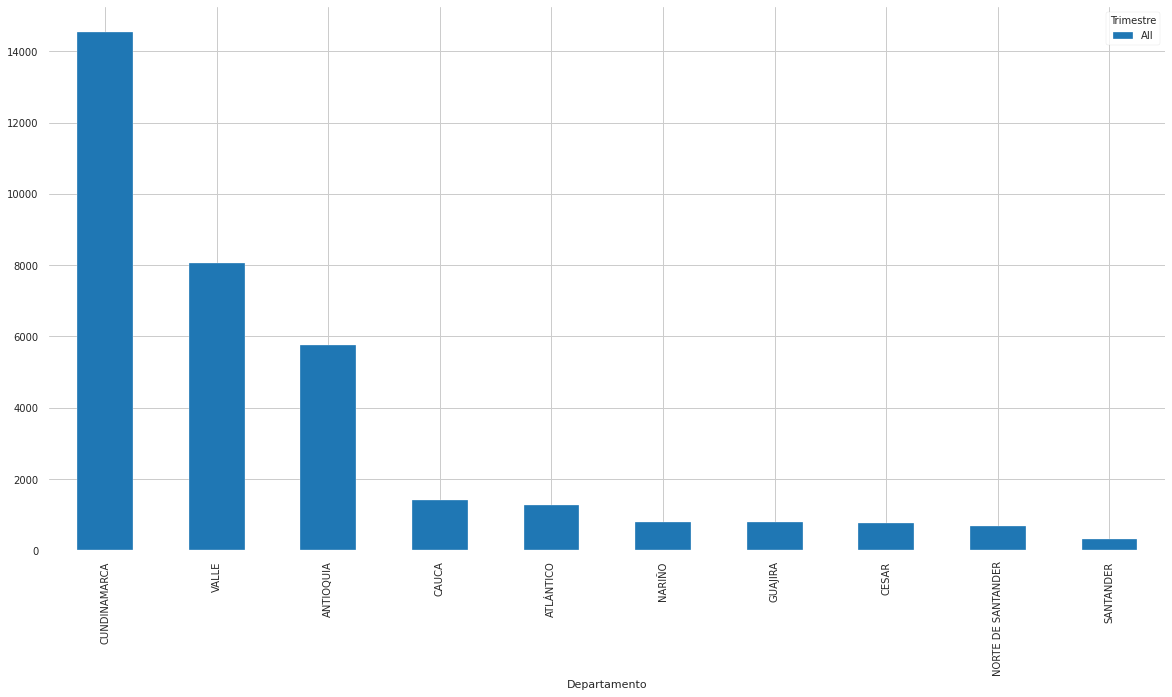

In [145]:
df_hurtos_top[["All"]].drop('All', axis=0).plot(kind='bar',figsize=(20,10),legend=True)

<AxesSubplot:xlabel='Departamento'>

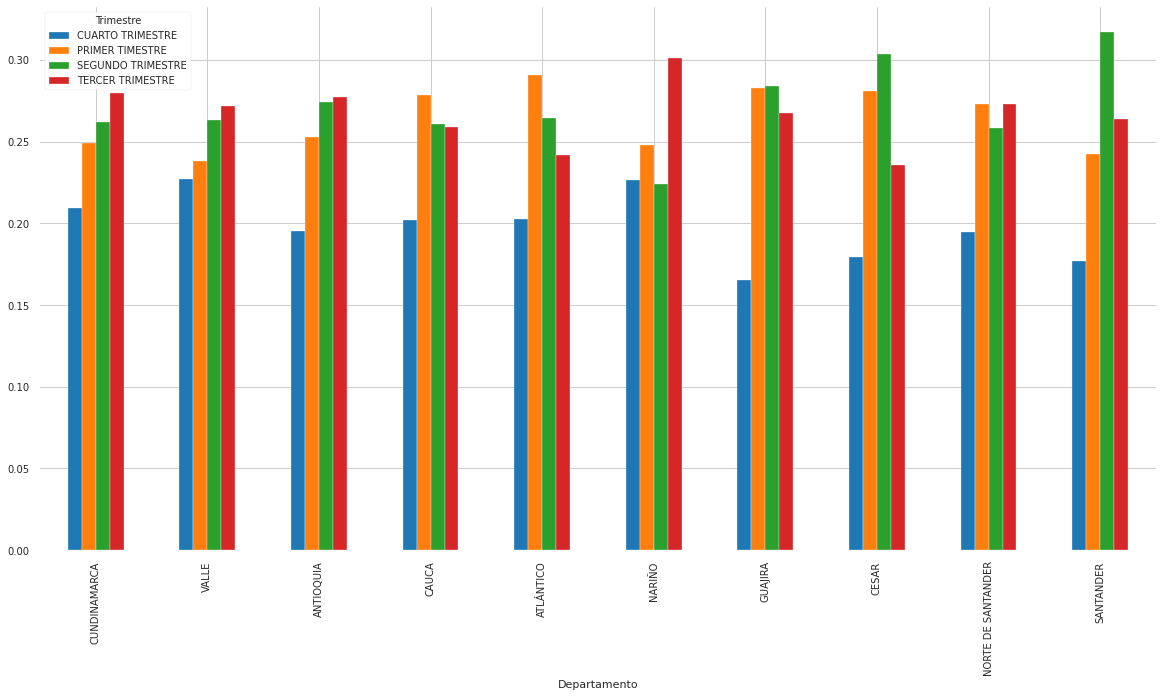

In [146]:
df_hurtos_cross_div.plot(kind='bar',figsize=(20,10),legend=True)

In [63]:
chi2, p, dof, ex =chi2_contingency(df_hurtos_mes_detartamento_c)

if (p < 0.05):
    print('La hora del robo de un vehiculo puede tener relacion con el departamento donde se comete el delito')
    print(p)

La hora del robo de un vehiculo puede tener relacion con el departamento donde se comete el delito
0.007095186267741113


In [129]:
# Trimestre VS Arma Empleada
df_hurtos_mes_arma_c = pd.crosstab(index=df_hurtos['Arma empleada'],columns=df_hurtos["Trimestre"],margins=True)
df_hurtos_mes_arma_c

Trimestre,CUARTO TRIMESTRE,PRIMER TIMESTRE,SEGUNDO TRIMESTRE,TERCER TRIMESTRE,All
Arma empleada,,,,,
-,3,1,4,3,11
ARMA BLANCA / CORTOPUNZANTE,110,150,141,127,528
ARMA DE FUEGO,1939,2304,2518,2503,9264
CONTUNDENTES,13,82,50,42,187
ESCOPOLAMINA,77,84,100,110,371
JERINGA,0,1,0,0,1
LLAVE MAESTRA,3910,4722,4968,4941,18541
NO REPORTADO,316,208,391,348,1263
SIN EMPLEO DE ARMAS,1259,1676,1531,1915,6381


In [141]:
df_hurtos_mes_arma = df_hurtos_mes_arma_c.div(df_hurtos_mes_arma_c.All, axis=0)
df_hurtos_mes_arma = df_hurtos_mes_arma_c.drop(['All'], axis=1).drop('All', axis=0).head(5)

<AxesSubplot:xlabel='Arma empleada'>

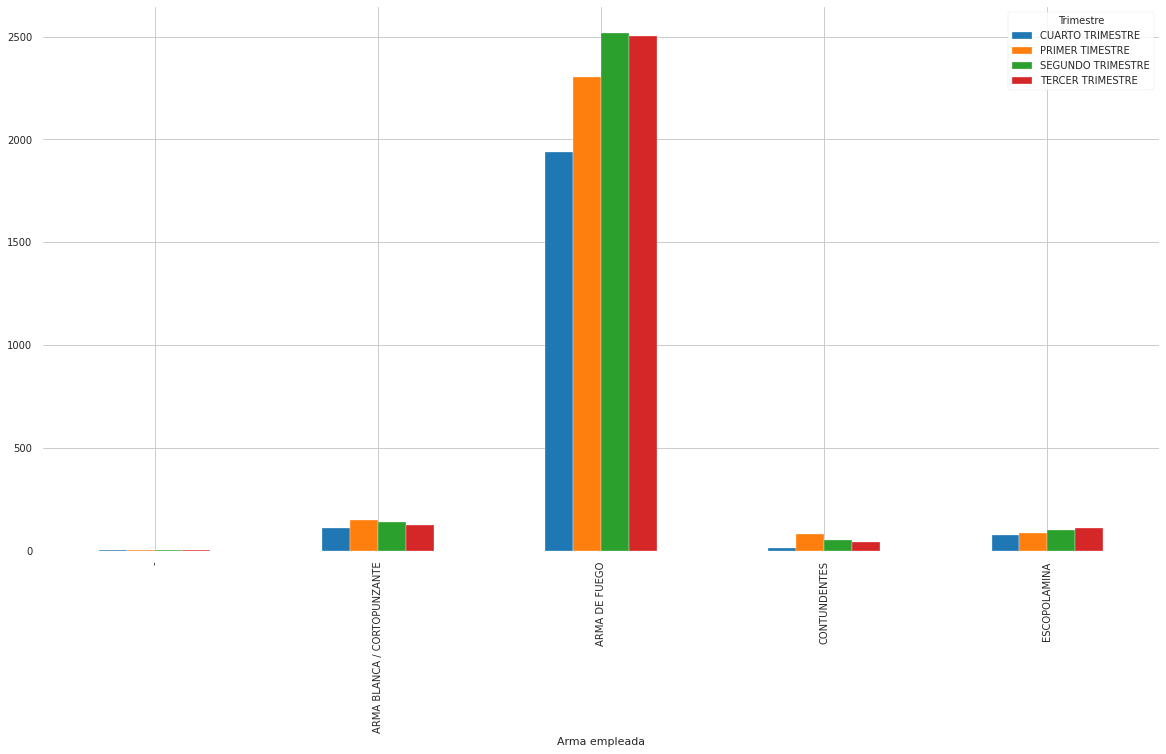

In [142]:
df_hurtos_mes_arma.plot(kind='bar',figsize=(20,10),legend=True)

In [71]:
chi2, p, dof, ex =chi2_contingency(df_hurtos_mes_arma_c)

if (p < 0.05):
    print('El trimestre del robo de un vehiculo puede tener relacion con el arma utilizada')
    print(p)

La hora del robo de un vehiculo puede tener relacion con el arma utilizada
2.0080835746880383e-17


In [127]:
# Mes, sitio
df_hurtos_mes_sitio_c = pd.crosstab(index=df_hurtos["Clase de sitio"],columns=df_hurtos["Trimestre"],margins=True)
df_hurtos_mes_sitio_top = df_hurtos_mes_sitio_c.sort_values("All", ascending=False).head(10)
#df_hurtos_mes_sitio_top = df_hurtos_mes_sitio_c.T.sort_values("All", ascending=False).iloc[:10].T
df_hurtos_mes_sitio_top = df_hurtos_mes_sitio_top.div(df_hurtos_mes_sitio_top["All"],axis=0).drop("All",axis=1).drop("All",axis=0)

<AxesSubplot:xlabel='Clase de sitio'>

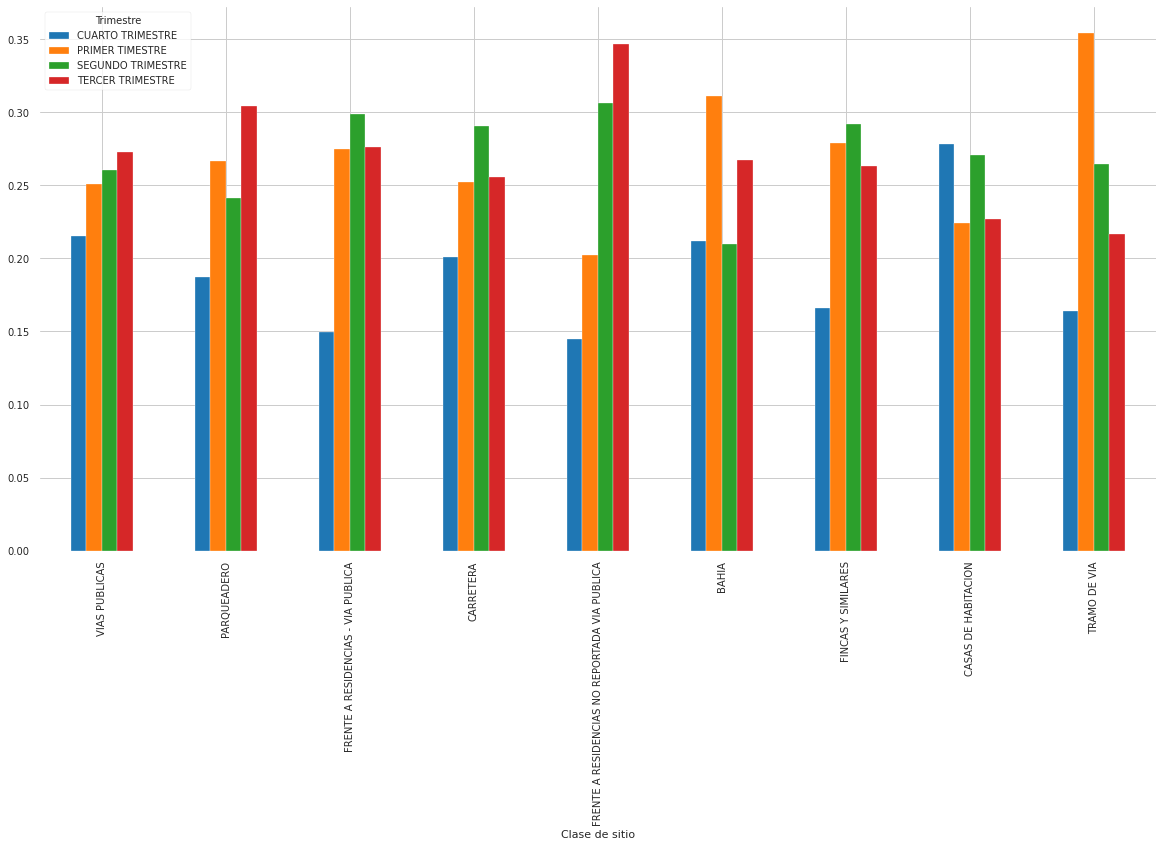

In [128]:
df_hurtos_mes_sitio_top.plot(kind='bar',figsize=(20,10),legend=True)

In [80]:
chi2, p, dof, ex =chi2_contingency(df_hurtos_mes_sitio_c)

if (p < 0.05):
    print('El trimestre del robo de un vehiculo puede tener relacion con el sitio')
    print(p)

El trimestre del robo de un vehiculo puede tener relacion con el sitio
1.2396633170730738e-24


In [149]:
# Mes, Grupo Etario
df_hurtos_mes_getario_c = pd.crosstab(index=df_hurtos["Trimestre"],columns=df_hurtos["Grupo_Etario"],margins=True)
df_hurtos_mes_getario = df_hurtos_mes_getario_c.sort_values("All", ascending=False)
df_hurtos_mes_getario = df_hurtos_mes_getario.div(df_hurtos_mes_getario["All"],axis=0).drop("All",axis=1).drop("All",axis=0)

<AxesSubplot:xlabel='Trimestre'>

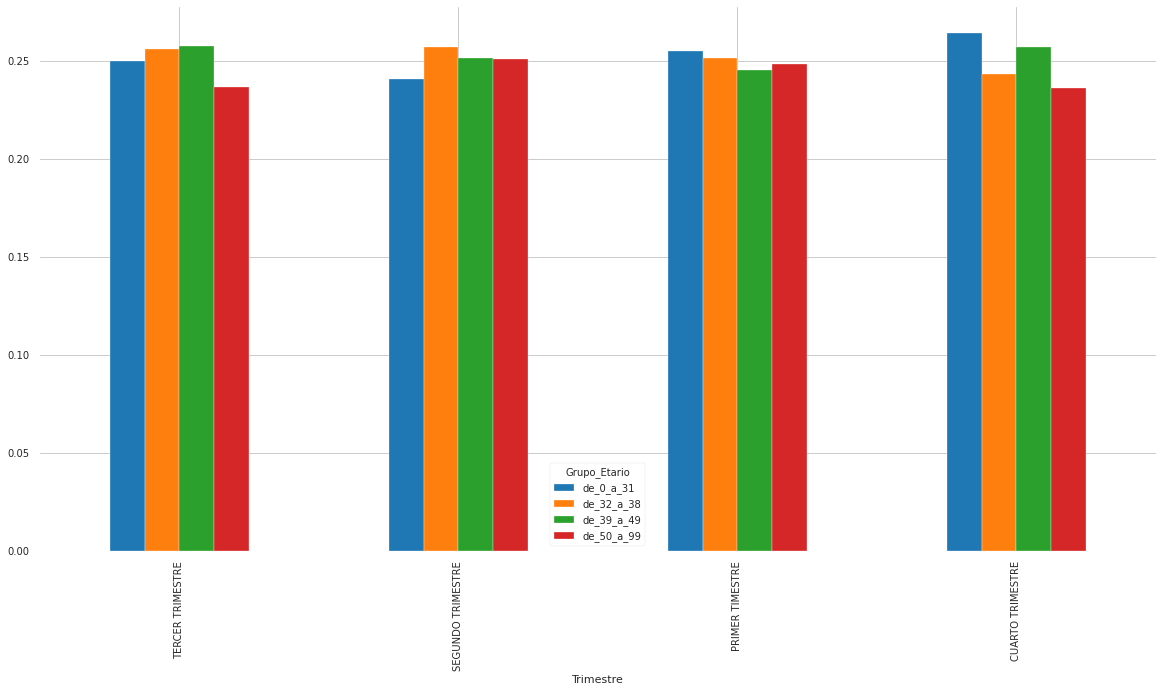

In [150]:
df_hurtos_mes_getario.plot(kind='bar',figsize=(20,10),legend=True)

In [151]:
chi2, p, dof, ex =chi2_contingency(df_hurtos_mes_getario)

if (p < 0.05):
    print('El trimestre del robo puede tener relacion con el sitio')
    print(p)

In [154]:
#Mes - Genero
df_hurtos_mes_sexo_c = pd.crosstab(index=df_hurtos["Sexo"],columns=df_hurtos["Trimestre"],margins=True)
df_hurtos_mes_sexo = df_hurtos_mes_sexo_c.sort_values("All", ascending=False)
df_hurtos_mes_sexo = df_hurtos_mes_sexo.div(df_hurtos_mes_sexo["All"],axis=0).drop("All",axis=1).drop("All",axis=0)

<AxesSubplot:xlabel='Sexo'>

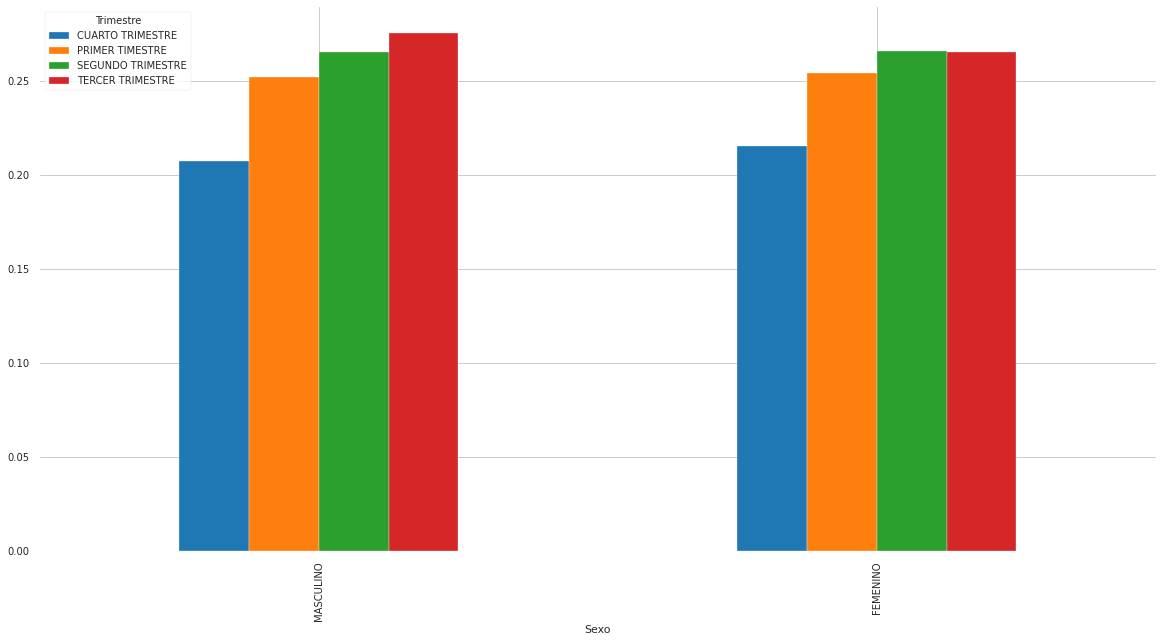

In [156]:
df_hurtos_mes_sexo.plot(kind='bar',figsize=(20,10),legend=True)

In [159]:
#Mes - Marca
df_hurtos_mes_marca_c = pd.crosstab(index=df_hurtos["MARCA"],columns=df_hurtos["Trimestre"],margins=True)
df_hurtos_mes_marca = df_hurtos_mes_marca_c.sort_values("All", ascending=False).head(15).drop("All",axis=1).drop("All",axis=0)


<AxesSubplot:xlabel='MARCA'>

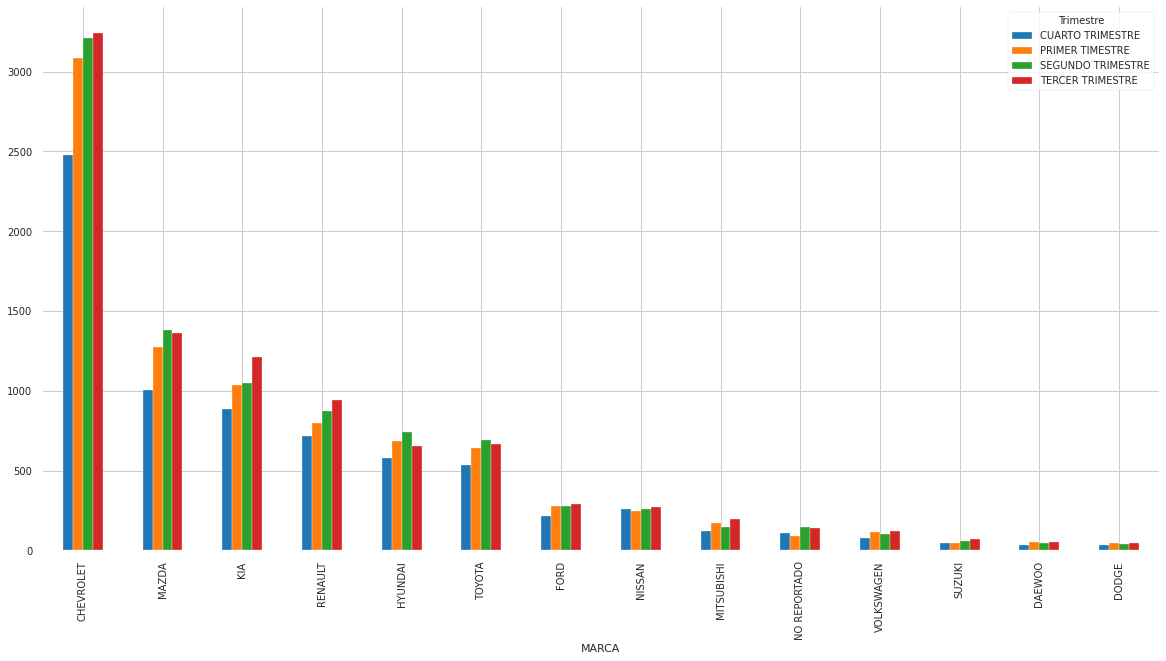

In [160]:
df_hurtos_mes_marca.plot(kind='bar',figsize=(20,10),legend=True)

In [ ]:
#Mes - Hora
df_hurtos_mes_hora_c = pd.crosstab(index=df_hurtos["Hora_Cat"],columns=df_hurtos["Trimestre"],margins=True)
df_hurtos_mes_hora = df_hurtos_mes_marca_c.sort_values("All", ascending=False).head(15).drop("All",axis=1).drop("All",axis=0)


## Análisis Multivariado



In [262]:
df_multivariate = pd.concat([df_hurtos_hora_sitio_top,df_hurtos_hora_arma],axis=1)

In [263]:
df_multivariate

,VIAS PUBLICAS,PARQUEADERO,FRENTE A RESIDENCIAS - VIA PUBLICA,CARRETERA,FRENTE A RESIDENCIAS NO REPORTADA VIA PUBLICA,BAHIA,FINCAS Y SIMILARES,CASAS DE HABITACION,TRAMO DE VIA,-,ARMA BLANCA / CORTOPUNZANTE,ARMA DE FUEGO,CONTUNDENTES,ESCOPOLAMINA,JERINGA,LLAVE MAESTRA,NO REPORTADO,SIN EMPLEO DE ARMAS
(00-04],0.754947,0.037409,0.062890,0.020602,0.015451,0.007590,0.012470,0.015722,0.005693,0.000271,0.021957,0.206289,0.005964,0.014638,0.000000,0.490919,0.044185,0.215777
(04-08],0.703087,0.041750,0.081945,0.032423,0.028648,0.013102,0.012658,0.008217,0.009327,0.000222,0.009771,0.170553,0.005330,0.007328,0.000000,0.586942,0.030424,0.189429
(08-12],0.754563,0.052147,0.031114,0.027812,0.011472,0.011820,0.012863,0.010603,0.007474,0.000000,0.008865,0.190162,0.003650,0.013732,0.000000,0.556579,0.025030,0.201982
(12-16),0.761181,0.045084,0.025349,0.034583,0.009958,0.015390,0.012855,0.007967,0.008510,0.000362,0.012493,0.224697,0.005794,0.019192,0.000000,0.542097,0.024262,0.171103
(16-20],0.780612,0.035580,0.026316,0.030209,0.009264,0.016649,0.015977,0.011278,0.009533,0.000269,0.011144,0.263963,0.005639,0.007250,0.000000,0.571294,0.022691,0.117750
(20-24],0.784550,0.043609,0.029384,0.019936,0.009760,0.009241,0.008826,0.010798,0.004569,0.000519,0.020766,0.356557,0.004776,0.004672,0.000104,0.377531,0.053577,0.181497


In [281]:
df_multivariate.T

,(00-04],(04-08],(08-12],(12-16),(16-20],(20-24]
VIAS PUBLICAS,0.754947,0.703087,0.754563,0.761181,0.780612,0.784550
PARQUEADERO,0.037409,0.041750,0.052147,0.045084,0.035580,0.043609
FRENTE A RESIDENCIAS - VIA PUBLICA,0.062890,0.081945,0.031114,0.025349,0.026316,0.029384
CARRETERA,0.020602,0.032423,0.027812,0.034583,0.030209,0.019936
FRENTE A RESIDENCIAS NO REPORTADA VIA PUBLICA,0.015451,0.028648,0.011472,0.009958,0.009264,0.009760
BAHIA,0.007590,0.013102,0.011820,0.015390,0.016649,0.009241
FINCAS Y SIMILARES,0.012470,0.012658,0.012863,0.012855,0.015977,0.008826
CASAS DE HABITACION,0.015722,0.008217,0.010603,0.007967,0.011278,0.010798
TRAMO DE VIA,0.005693,0.009327,0.007474,0.008510,0.009533,0.004569
-,0.000271,0.000222,0.000000,0.000362,0.000269,0.000519


In [284]:
pca = PCA(n_components=2)
pca.fit(df_multivariate.T)
list_pca = pca.transform(df_multivariate.T)
print(pca.explained_variance_ratio_)
df_PCA = pd.DataFrame(list_pca, columns=["PCA_1","PCA_2"])


[0.98571821 0.01143038]


In [286]:
dict_ = dict()
for column_pca in df_PCA.columns:
    corr_list = []
    for column_transformed in df_multivariate.T.columns:
        corr_list.append(stats.spearmanr(df_multivariate.T[column_transformed].tolist(),df_PCA[column_pca].tolist())[0])
    dict_[f"corr_{column_pca}"] = corr_list

In [288]:
pd.DataFrame(dict_,index=df_multivariate.T.columns)

,corr_PCA_1,corr_PCA_2
(00-04],0.960784,-0.083591
(04-08],0.971104,0.093911
(08-12],0.945793,0.094992
(12-16),0.952528,0.058824
(16-20],0.940144,-0.031992
(20-24],0.960784,-0.172343
